## L2L by GD by GD - simple

Target of this notebook is to reproduce some of the results from DeepMind’s paper [“Learning to learn by gradient descent by gradient descent”](https://arxiv.org/abs/1606.04474) and hopefully explore some of the doors it opens.
This paper was pointed out to me by Cyprien de Masson who works at ... you guessed it ... DeepMind.
@Cyprien : thanks for that !  
I was, at the time, scrabbling in the dark, trying to construct an optimizer with a very simple neural network structure, but using bayesian optimization to find the good parameters, instead of the good old gradient descent, because it seemed simpler as an initial approach and avoided having to deal with the memory problem of loading 100s of tensorflow graph into a single graph (corresponding to the number of iterations). Also I wasn't sure a problem with such chaotic behaviour as gradient descent could be optimized by gradient descent (i was thinking, the scope of optimization would have to be limited to 10 or 20 steps to have meaningful gradients)
I have also re-used Llion Jones's very simple, yet efficient way of implementing “Learning to learn" ideas as explained in ["Learning to Learn by Gradient Descent by Gradient Descent - As simple as possible in TensorFlow"](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2)

Let's start by importing tensorflow and a couple of usefull tools

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

If you are using the GPU version of tensorflow you can choose which PU to use. Here I'm using the CPU because I'll start with small problems where GPU don't really speeds things up.

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

### Summary of Llion Jone's Notebook

Just to be clear, the code in this section is, more or less, a copy paste from [Llion Jones's article](https://hackernoon.com/learning-to-learn-by-gradient-descent-by-gradient-descent-4da2273d64f2).  
I encourage you to read it if you want to understand how it is set-up

In [3]:
DIMS = 2  # Dimensions of the quadratic function, the simplest application problem in DeepMind's paper

scale = tf.random_uniform([DIMS], 0.5, 1.5)
# The scale vector gives a different shape to the quadratic function at each initialization 

def quadratic(x):
  x = scale*x
  return tf.reduce_sum(tf.square(x))

In [4]:
# Some reference optimizers for benchmarking

def g_sgd(gradients, state, learning_rate=0.1):
  # Vanilla Stochastic Gradient Descent
  return -learning_rate*gradients, state

def g_rms(gradients, state, learning_rate=0.1, decay_rate=0.99):
  # RMSProp
  if state is None:
    state = tf.zeros(DIMS)
  state = decay_rate*state + (1-decay_rate)*tf.pow(gradients, 2)
  update = -learning_rate*gradients / (tf.sqrt(state)+1e-5)
  return update, state

In [5]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses

In [6]:
sgd_losses = learn(g_sgd)
rms_losses = learn(g_rms)

In [7]:
# Now let's define the RNN optimizer
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
  [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

In [38]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  return optimizer.apply_gradients(zip(gradients, v))

In [9]:
def print_dict(*args):
  # Prints variables in a dict format for easier reading
  dict_name = dict((name,eval(name)) for name in args)
  print(dict_name)

In [10]:
def graph_optimizers(f1, f2, f3, it=3, training_steps=TRAINING_STEPS):
  # Graph to compare RNN to the 2 baseline optimizers
  x = np.arange(training_steps)
  for _ in range(it): 
    sgd_l, rms_l, rnn_l = sess.run([f1, f2, f3])
    p1, = plt.semilogy(x, sgd_l, label='SGD')
    p2, = plt.semilogy(x, rms_l, label='RMS')
    p3, = plt.semilogy(x, rnn_l, label='RNN')
    plt.legend(handles=[p1, p2, p3])
    plt.title('Losses')
    plt.show()

In [11]:
def rolling_log_average(array, L):
  # Rolling average of the log of the array over a length of L
  rolling_av = np.array([])
  for i in range(array.size):
    rolling_av = np.append(rolling_av, 10**(np.log10(array[:i+1][-L:] + 1e-38).mean()))
  return rolling_av

In [12]:
def draw_convergence(*args):
  # Draws the convergence of one or several meta optimizations
  it = 0
  for f in args:
    it = max(eval(f).size, it)
  handles = []
  for f in args:
    flist = eval(f)
    flist_rolling = rolling_log_average(flist, 500)
    flist_size = flist.size
    if flist_size < it:
      flist = np.append(flist, [None]*(it-flist_size))
      flist_rolling = np.append(flist_rolling, [None]*(it-flist_size))
    c1, = plt.semilogy(range(it), flist, alpha=0.3)
    c2, = plt.semilogy(range(it), flist_rolling, color=c1.get_color(), label=f)
    handles = handles + [c2]
  plt.legend(handles=handles)
  plt.title('End result of the RNN')
  plt.show()

In [13]:
class Log_casting:
  ### Class used to cast logarithmically vectors from a variable range of scales below one to [-1, 1]
  
  def __init__(self, init):
    # scalar of the minimum log(gradient) encountered, initialized at -10
    self.min_log_value = tf.Variable(float(init), name="min_log_value", trainable=False)
    # vector identity multiplied by min_log_value, initialized as None
    self.min_log = None
  
  def update_min_log(self, vector):
    # This method is called at each iteration of the meta optimizer to adapt the min_log_value based on the
    # last gradient (iteration 20) returned by the learn2 function (defined below)
    log_vector = tf.log(tf.abs(vector) + 1e-38)
    # update proposal based on the gradient, the factor 0.01 is to avoid losing the RNN with a sudden big shift
    update_proposal = 0.01*tf.reduce_min(log_vector) + 0.99 * self.min_log_value
    # the update is applied only if it is lower than the current value
    new_value = tf.assign(self.min_log_value, tf.minimum(update_proposal, self.min_log_value))
    return new_value
  
  def preprocess(self, gradients):
    # Casting of gradients from [exp(min_log_value), 1] to [0, 1] and [-1, -exp(min_log_value)] to [-1, 0]
    self.min_log = tf.ones_like(gradients, name='MIN_LOG')*self.min_log_value
    log_gradients = tf.log(tf.abs(gradients) + 1e-38)
    sign_gradients = tf.sign(gradients)
    inputs = tf.multiply(sign_gradients,((log_gradients - self.min_log) / (- self.min_log)))
    return inputs
  
  def postprocess(self, outputs):
    # Casting back RNN output from [0, 1] to [exp(min_log_value), 1] and [-1, 0] to [-1, -exp(min_log_value)] 
    self.min_log = tf.ones_like(outputs, name='MIN_LOG')*self.min_log_value
    abs_outputs = tf.abs(outputs)
    sign_outputs = tf.sign(outputs)
    update = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- self.min_log) + self.min_log))
    return update

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
def g_rnn_div1(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  update, state[0] = cell(inputs, state[0])
  outputs = tf.multiply(update, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  # Squeeze to make it a single batch again.
  return tf.squeeze(outputs, axis=[1]), state

rnn_losses = learn(g_rnn_div1)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div1_sum_log_res = list_result

{'it': 0, 'optim_result': '3.60E-03', 'av_log_res': '-2.44', 'av_sum_log_res': '-1.05'}
{'it': 10000, 'optim_result': '1.15E-17', 'av_log_res': '-16.92', 'av_sum_log_res': '-7.98'}
{'it': 20000, 'optim_result': '1.46E-22', 'av_log_res': '-25.38', 'av_sum_log_res': '-10.01'}
{'it': 30000, 'optim_result': '8.75E-29', 'av_log_res': '-28.95', 'av_sum_log_res': '-11.29'}
{'it': 40000, 'optim_result': '2.19E-38', 'av_log_res': '-30.33', 'av_sum_log_res': '-12.09'}
{'it': 50000, 'optim_result': '2.59E-33', 'av_log_res': '-31.15', 'av_sum_log_res': '-12.66'}
{'it': 60000, 'optim_result': '0.00E+00', 'av_log_res': '-32.27', 'av_sum_log_res': '-13.12'}
{'it': 70000, 'optim_result': '1.38E-35', 'av_log_res': '-33.31', 'av_sum_log_res': '-13.53'}
{'it': 80000, 'optim_result': '0.00E+00', 'av_log_res': '-33.48', 'av_sum_log_res': '-13.85'}
{'it': 90000, 'optim_result': '1.55E-36', 'av_log_res': '-34.38', 'av_sum_log_res': '-14.17'}
{'it': 100000, 'optim_result': '2.76E-31', 'av_log_res': '-33.55', 

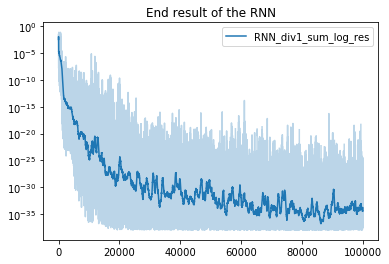

In [18]:
draw_convergence('RNN_div1_sum_log_res')

In [19]:
def g_rnn_div2(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  #else:
    #gradients = tf.where(tf.is_nan(gradients), state[1], gradients)
  inputs = tf.divide(gradients, state[1] + tf.sign(state[1])*1e-37)
  outputs, state[0] = cell(inputs, state[0])
  update = tf.multiply(outputs, state[1] + tf.sign(state[1])*1e-37)
  state[1] = gradients
  #update = tf.where(tf.is_nan(update), gradients*1e-1, outputs)
  #for ll in state[0]:
    #for l in ll:
      #l = tf.where(tf.is_nan(l), tf.ones_like(l)*1e-6, l)
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_div1)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_div2_sum_log_res = list_result

{'it': 0, 'optim_result': '1.18E-04', 'av_log_res': '-3.93', 'av_sum_log_res': '-2.34'}
{'it': 10000, 'optim_result': '3.75E-25', 'av_log_res': '-18.38', 'av_sum_log_res': '-8.37'}
{'it': 20000, 'optim_result': '1.22E-25', 'av_log_res': '-25.60', 'av_sum_log_res': '-10.15'}
{'it': 30000, 'optim_result': '1.60E-31', 'av_log_res': '-28.05', 'av_sum_log_res': '-11.15'}
{'it': 40000, 'optim_result': '0.00E+00', 'av_log_res': '-30.06', 'av_sum_log_res': '-11.91'}
{'it': 50000, 'optim_result': '1.98E-25', 'av_log_res': '-31.24', 'av_sum_log_res': '-12.46'}
{'it': 60000, 'optim_result': '1.73E-25', 'av_log_res': '-30.65', 'av_sum_log_res': '-12.78'}
{'it': 70000, 'optim_result': '2.96E-34', 'av_log_res': '-31.61', 'av_sum_log_res': '-13.08'}
{'it': 80000, 'optim_result': '1.08E-28', 'av_log_res': '-32.47', 'av_sum_log_res': '-13.37'}
{'it': 90000, 'optim_result': '2.43E-29', 'av_log_res': '-30.93', 'av_sum_log_res': '-13.50'}
{'it': 100000, 'optim_result': '1.99E-29', 'av_log_res': '-31.13', 

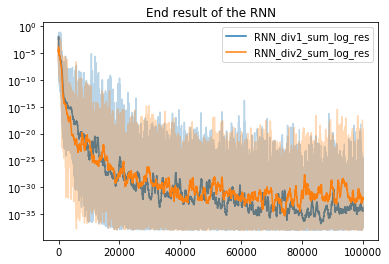

In [20]:
draw_convergence('RNN_div1_sum_log_res', 'RNN_div2_sum_log_res')

In [48]:
tuple1 = (1,2,3,4,5)
tuple2 = ()
for l in list_:
  l = l+1
  tuple2 = tuple2 + (l,)
print(tuple2)
print(tuple2[1])

(2, 3, 4, 5, 6)
3


In [63]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  print(gradients)
  print(tf.clip_by_global_norm(gradients, 1.))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  print(gradients)
  return optimizer.apply_gradients(zip(gradients, v))

In [61]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients = tf.clip_by_global_norm(gradients, 1.)
  grad_check = tf.check_numerics(clipped_gradients, 'nan found in gradient')
  with tf.control_dependencies([grad_check]):
    checked_optimizer = optimizer.apply_gradients(zip(clipped_gradients, v))
  return checked_optimizer

tf.Print(clipped_gradients, clipped_gradients)

In [67]:
def optimize(loss, learning_rate=0.1):
  # "Meta optimizer" to be applied on the RNN defined above
  optimizer = tf.train.AdamOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
  checked_gradients = []
  for g in clipped_gradients:
    checked_g = tf.where(tf.is_nan(g), tf.zeros_like(g), g)
    checked_gradients = checked_gradients + [checked_g]
  return optimizer.apply_gradients(zip(checked_gradients, v))

In [68]:
Log_casting_ = Log_casting(-5)

def g_rnn_logdiv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  inputs = Log_casting_.preprocess(inputs_)
  outputs, state[0] = cell(inputs, state[0])
  outputs_ = Log_casting_.postprocess(outputs)
  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  state[2] = inputs_
  return tf.squeeze(update, axis=[1]), state

def learn3(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    #state = tf.where(tf.is_nan(new_state), state, new_state)
    x += update
  return losses, state[2] # the last RNN input is added to the ouptut for use by Log_casting

rnn_losses, RNN_inputs = learn3(g_rnn_logdiv) # grads output added for use by log_casting
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
# the operation below gradually adapts the min_log value to the lowest gardient ratio
update_log_casting = Log_casting_.update_min_log(RNN_inputs)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logdiv_sum_log_res = list_result

{'it': 0, 'optim_result': '2.24E-01', 'av_log_res': '-0.65', 'av_sum_log_res': '-0.59', 'min_log': '-5.00'}
{'it': 10000, 'optim_result': '5.25E-25', 'av_log_res': '-15.31', 'av_sum_log_res': '-7.24', 'min_log': '-6.15'}
{'it': 20000, 'optim_result': '1.59E-21', 'av_log_res': '-25.63', 'av_sum_log_res': '-9.59', 'min_log': '-7.03'}
{'it': 30000, 'optim_result': '0.00E+00', 'av_log_res': '-33.31', 'av_sum_log_res': '-11.67', 'min_log': '-7.74'}
{'it': 40000, 'optim_result': '0.00E+00', 'av_log_res': '-35.55', 'av_sum_log_res': '-13.15', 'min_log': '-8.12'}
{'it': 50000, 'optim_result': '0.00E+00', 'av_log_res': '-36.31', 'av_sum_log_res': '-14.25', 'min_log': '-8.40'}
{'it': 60000, 'optim_result': '0.00E+00', 'av_log_res': '-36.48', 'av_sum_log_res': '-15.05', 'min_log': '-8.67'}
{'it': 70000, 'optim_result': '4.72E-35', 'av_log_res': '-36.72', 'av_sum_log_res': '-15.67', 'min_log': '-8.81'}
{'it': 80000, 'optim_result': '0.00E+00', 'av_log_res': '-36.75', 'av_sum_log_res': '-16.16', 'm

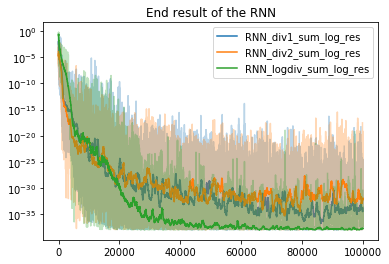

In [69]:
draw_convergence('RNN_div1_sum_log_res', 'RNN_div2_sum_log_res', 'RNN_logdiv_sum_log_res')

In [74]:
Log_casting_ = Log_casting(-5)

def g_rnn_logdiv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  inputs = Log_casting_.preprocess(inputs_)
  outputs, state[0] = cell(inputs, state[0])
  outputs_ = Log_casting_.postprocess(outputs)
  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  state[2] = inputs_
  return tf.squeeze(update, axis=[1]), state

def learn3(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    #state = tf.where(tf.is_nan(new_state), state, new_state)
    x += update
  return losses, state[2] # the last RNN input is added to the ouptut for use by Log_casting

rnn_losses, RNN_inputs = learn3(g_rnn_logdiv) # grads output added for use by log_casting
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)
# the operation below gradually adapts the min_log value to the lowest gardient ratio
update_log_casting = Log_casting_.update_min_log(RNN_inputs)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(200001):
  errors, _, min_log = sess.run([rnn_losses, apply_update, update_log_casting])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 20000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.nanmean(np.log10(list_result[-20000:] + 1e-37)))
    av_sum_log_res = '{:.2f}'.format(np.nanmean(list_sum_log_res))
    min_log = '{:.2f}'.format(min_log)
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res', 'min_log')

RNN_logdiv_sum_log_res = list_result

{'it': 0, 'optim_result': '4.64E-01', 'av_log_res': '-0.33', 'av_sum_log_res': '-0.23', 'min_log': '-5.00'}
{'it': 20000, 'optim_result': '1.85E-25', 'av_log_res': '-22.00', 'av_sum_log_res': '-10.17', 'min_log': '-6.91'}
{'it': 40000, 'optim_result': '0.00E+00', 'av_log_res': '-34.30', 'av_sum_log_res': '-13.41', 'min_log': '-8.06'}
{'it': 60000, 'optim_result': '0.00E+00', 'av_log_res': '-36.72', 'av_sum_log_res': '-15.36', 'min_log': '-8.85'}
{'it': 80000, 'optim_result': '0.00E+00', 'av_log_res': '-36.85', 'av_sum_log_res': '-16.48', 'min_log': '-9.11'}
{'it': 100000, 'optim_result': '0.00E+00', 'av_log_res': 'nan', 'av_sum_log_res': 'nan', 'min_log': '-9.58'}
{'it': 120000, 'optim_result': '1.29E-37', 'av_log_res': '-36.92', 'av_sum_log_res': 'nan', 'min_log': '-9.85'}
{'it': 140000, 'optim_result': '0.00E+00', 'av_log_res': '-36.92', 'av_sum_log_res': 'nan', 'min_log': '-10.03'}
{'it': 160000, 'optim_result': '0.00E+00', 'av_log_res': '-36.94', 'av_sum_log_res': 'nan', 'min_log':

In [93]:
test = np.array([0,2,np.nan,4])
print(np.nanmean(test))


2.0


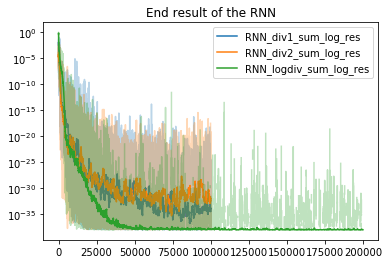

In [75]:
draw_convergence('RNN_div1_sum_log_res', 'RNN_div2_sum_log_res', 'RNN_logdiv_sum_log_res')

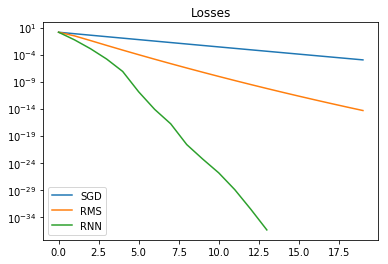

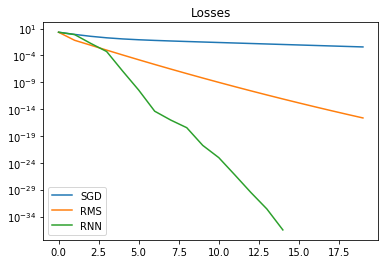

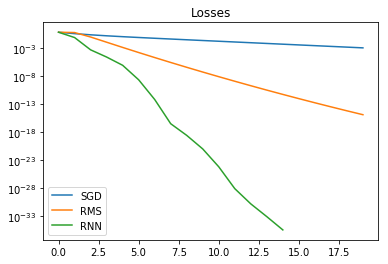

In [76]:
graph_optimizers(sgd_losses, rms_losses, rnn_losses)

In [77]:
def g_rnn_log8div(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  
  # Casting of inputs from [exp(-43), 1] to [0, 1] and [-1, -exp(-43)] to [-1, 0]
  min_log_gradient = -8
  log_inputs_ = tf.log(tf.abs(inputs_) + np.exp(min_log_gradient-2))
  sign_gradients = tf.sign(gradients)
  inputs = tf.multiply(sign_gradients,((log_inputs_ - min_log_gradient) / (- min_log_gradient)))
  
  outputs, state[0] = cell(inputs, state[0])
  
  # Casting of output from [0, 1] to [exp(-43), 1]  and [-1, 0] to [-1, -exp(-43)]
  abs_outputs = tf.abs(outputs)
  sign_outputs = tf.sign(outputs)
  outputs_ = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- min_log_gradient) + min_log_gradient))

  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_log8div)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0001)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(200001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 20000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-20000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_log8div_sum_log_res = list_result

{'it': 0, 'optim_result': '9.70E-01', 'av_log_res': '-0.01', 'av_sum_log_res': '-0.00'}
{'it': 20000, 'optim_result': '3.14E-15', 'av_log_res': '-7.12', 'av_sum_log_res': '-3.20'}
{'it': 40000, 'optim_result': '2.68E-27', 'av_log_res': '-22.37', 'av_sum_log_res': '-6.78'}
{'it': 60000, 'optim_result': '1.01E-26', 'av_log_res': '-25.28', 'av_sum_log_res': '-8.48'}
{'it': 80000, 'optim_result': '1.94E-26', 'av_log_res': '-27.36', 'av_sum_log_res': '-9.52'}
{'it': 100000, 'optim_result': '0.00E+00', 'av_log_res': '-32.85', 'av_sum_log_res': '-10.64'}
{'it': 120000, 'optim_result': '0.00E+00', 'av_log_res': '-35.74', 'av_sum_log_res': '-11.72'}
{'it': 140000, 'optim_result': '0.00E+00', 'av_log_res': '-36.76', 'av_sum_log_res': '-12.65'}
{'it': 160000, 'optim_result': '0.00E+00', 'av_log_res': '-36.86', 'av_sum_log_res': '-13.39'}
{'it': 180000, 'optim_result': '0.00E+00', 'av_log_res': '-36.89', 'av_sum_log_res': '-13.99'}
{'it': 200000, 'optim_result': '0.00E+00', 'av_log_res': '-36.93',

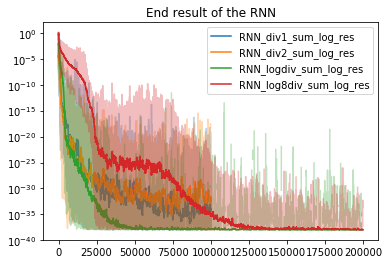

In [78]:
draw_convergence('RNN_div1_sum_log_res', 'RNN_div2_sum_log_res', 'RNN_logdiv_sum_log_res',
                 'RNN_log8div_sum_log_res')

In [208]:
def g_rnn_logdiv(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  inputs_ = tf.divide(gradients, tf.abs(state[1]) + 1e-37)
  
  # Casting of inputs from [exp(-43), 1] to [0, 1] and [-1, -exp(-43)] to [-1, 0]
  min_log_gradient = -5
  log_inputs_ = tf.log(tf.abs(inputs_) + np.exp(min_log_gradient-2))
  sign_gradients = tf.sign(gradients)
  inputs = tf.multiply(sign_gradients,((log_inputs_ - min_log_gradient) / (- min_log_gradient)))
  
  outputs, state[0] = cell(inputs, state[0])
  
  # Casting of output from [0, 1] to [exp(-43), 1]  and [-1, 0] to [-1, -exp(-43)]
  abs_outputs = tf.abs(outputs)
  sign_outputs = tf.sign(outputs)
  outputs_ = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- min_log_gradient) + min_log_gradient))

  update = tf.multiply(outputs_, tf.abs(state[1]) + 1e-37)
  state[1] = gradients
  return tf.squeeze(update, axis=[1]), state

rnn_losses = learn(g_rnn_logdiv)
sum_log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))
apply_update = optimize(sum_log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

list_result = np.array([])
list_sum_log_res = np.array([])
for it in range(100001):
  errors, _ = sess.run([rnn_losses, apply_update])
  list_result = np.append(list_result, errors[-1])
  list_sum_log_res = np.append(list_sum_log_res, np.log10(np.array(errors) + 1e-37).sum()/20)
  if it % 10000 == 0 :
    optim_result = '{:.2E}'.format(errors[-1])
    av_log_res = '{:.2f}'.format(np.log10(list_result[-10000:] + 1e-37).mean())
    av_sum_log_res = '{:.2f}'.format(list_sum_log_res.mean())
    print_dict('it', 'optim_result', 'av_log_res', 'av_sum_log_res')

RNN_log5div_sum_log_res = list_result

{'it': 0, 'optim_result': '2.91E+00', 'av_log_res': '0.46', 'av_sum_log_res': '0.30'}
{'it': 10000, 'optim_result': '8.68E-22', 'av_log_res': '-15.03', 'av_sum_log_res': '-6.99'}
{'it': 20000, 'optim_result': '1.62E-24', 'av_log_res': '-24.52', 'av_sum_log_res': '-9.23'}
{'it': 30000, 'optim_result': '2.22E-30', 'av_log_res': '-28.13', 'av_sum_log_res': '-10.72'}
{'it': 40000, 'optim_result': '7.99E-36', 'av_log_res': '-29.69', 'av_sum_log_res': '-11.62'}
{'it': 50000, 'optim_result': '1.56E-31', 'av_log_res': '-30.70', 'av_sum_log_res': '-12.26'}
{'it': 60000, 'optim_result': '1.21E-33', 'av_log_res': '-31.14', 'av_sum_log_res': '-12.72'}
{'it': 70000, 'optim_result': '0.00E+00', 'av_log_res': '-31.58', 'av_sum_log_res': '-13.09'}
{'it': 80000, 'optim_result': '1.33E-36', 'av_log_res': '-31.65', 'av_sum_log_res': '-13.36'}
{'it': 90000, 'optim_result': '1.45E-33', 'av_log_res': '-32.55', 'av_sum_log_res': '-13.62'}
{'it': 100000, 'optim_result': '1.16E-35', 'av_log_res': '-31.90', 'av

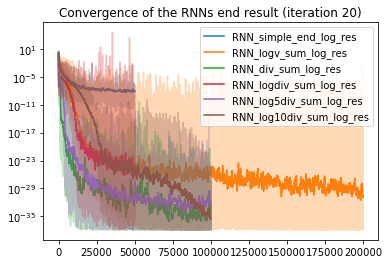

In [209]:
draw_convergence('RNN_simple_end_log_res', 'RNN_logv_sum_log_res', 'RNN_div_sum_log_res',
                 'RNN_logdiv_sum_log_res', 'RNN_log5div_sum_log_res', 'RNN_log10div_sum_log_res')

In [ ]:
rnn_losses = learn(g_rnn_div)
log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-30)))/np.log(10)
apply_update_log = optimize(log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

roll_err = np.array([])
roll_err_sum = np.array([])
for i in range(50000):
  errors, _ = sess.run([rnn_losses, apply_update_log])
  roll_err = np.append(roll_err, np.log10(errors[-1]+ 1e-30))
  roll_err_sum = np.append(roll_err_sum, np.log10(np.array(errors) + 1e-30).sum()/20)
  if i > 1000:
    roll_err = roll_err[1:]
    roll_err_sum = roll_err_sum[1:]
  if i % 5000 == 0:
    print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))
print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))

In [ ]:
for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=''):
    print(v)

In [ ]:
# Now let's define the RNN optimizer
LAYERS = 2
STATE_SIZE = 20

cell = tf.contrib.rnn.MultiRNNCell(
  [tf.contrib.rnn.LSTMCell(STATE_SIZE) for _ in range(LAYERS)])
cell = tf.contrib.rnn.InputProjectionWrapper(cell, STATE_SIZE)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 1)
cell = tf.make_template('cell', cell)

In [ ]:
def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  # The loop below unrolls the 20 steps of the optimizer into a single tensorflow graph
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, state

def g_rnn_log(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  print(gradients)
  gradients = tf.where(tf.is_nan(gradients), tf.add(tf.zeros_like(gradients),1e-37), gradients)
  
  if state is None:
    state = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
  
  # Casting of gradients from [exp(-37), 1] to [0, 1] and [-1, -exp(-37)] to [-1, 0]
  log_gradients = tf.log(tf.abs(gradients) + np.exp(-85))
  print(log_gradients)
  try:
    min_log = tf.get_default_graph().get_tensor_by_name("MIN_LOG:0")
    min_log = tf.assign(min_log, tf.minimum(tf.reduce_min(log_gradients), min_log))
  except:
    min_log = tf.ones_like(gradients, name='MIN_LOG')
  sign_gradients = tf.sign(gradients)
  print(sign_gradients, log_gradients, min_log)
  inputs = tf.multiply(sign_gradients,((log_gradients - min_log) / (- min_log)))

  print(inputs, state)
  outputs, state = cell(inputs, state)
  
  # Casting of output from [0, 1] to [exp(-38), 1]  and [-1, 0] to [-1, -exp(-38)]
  abs_outputs = tf.abs(outputs)
  sign_outputs = tf.sign(outputs)
  update = tf.multiply(sign_outputs, tf.exp(abs_outputs * (- min_log) + min_log))
  
  update = tf.where(tf.is_nan(update), gradients*1e-1, update)
  for ll in state:
    for l in ll:
      l = tf.where(tf.is_nan(l), tf.ones_like(l)*1e-6, l)
  
  return tf.squeeze(update, axis=[1]), state

rnn_losses, state_rnn = learn(g_rnn_log)
log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))/np.log(10)
apply_update_log = optimize(log_losses, learning_rate=0.001)

sess.run(tf.global_variables_initializer())

roll_err = np.array([])
roll_err_sum = np.array([])
for i in range(200000):
  errors, _ = sess.run([rnn_losses, apply_update_log])
  roll_err = np.append(roll_err, np.log10(errors[-1]+ 1e-37))
  roll_err_sum = np.append(roll_err_sum, np.log10(np.array(errors) + 1e-37).sum()/20)
  if i > 10000:
    roll_err = roll_err[1:]
    roll_err_sum = roll_err_sum[1:]
  if i % 10000 == 0:
    print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))
  if errors[-1] - roll_err.mean() > 10:
    print(sess.run([rnn_losses, state]))
    break
print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
))

In [ ]:
graph_semilogy(sgd_losses, rms_losses, rnn_losses)

In [ ]:
def g_rnn_div(gradients, state):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    state = [state_nn, gradients]
  #else:
    #gradients = tf.where(tf.is_nan(gradients), state[1], gradients)
  inputs = tf.divide(gradients, state[1] + tf.sign(state[1])*1e-37)
  #inputs = tf.clip_by_value(inputs, -1e6, 1e6)
  outputs, state[0] = cell(inputs, state[0])
  update = tf.multiply(outputs, state[1] + tf.sign(state[1])*1e-37)
  state[1] = gradients
  #update = tf.where(tf.is_nan(update), gradients*1e-1, outputs)
  #for ll in state[0]:
    #for l in ll:
      #l = tf.where(tf.is_nan(l), tf.ones_like(l)*1e-6, l)
  return tf.squeeze(update, axis=[1]), state

rnn_losses, state_rnn = learn(g_rnn_div)
log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))/np.log(10)
apply_update_log = optimize(log_losses, learning_rate=0.0003)

sess.run(tf.global_variables_initializer())

roll_err = np.array([])
roll_err_sum = np.array([])
for i in range(200000):
  errors, state_rnn_, _ = sess.run([rnn_losses, state_rnn, apply_update_log])
  roll_err = np.append(roll_err, np.log10(errors[-1]+ 1e-37))
  roll_err_sum = np.append(roll_err_sum, np.log10(np.array(errors) + 1e-37).sum()/20)
  if i > 5000:
    roll_err = roll_err[1:]
    roll_err_sum = roll_err_sum[1:]
  if i % 5000 == 0:
    print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))
  #if roll_err[-1] - roll_err.mean() > 15:
    #print(errors, state_rnn_)
    #break
print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
))

In [ ]:
graph_semilogy(sgd_losses, rms_losses, rnn_losses)

In [ ]:
rnn_losses, state_rnn = learn(g_rnn_div)
log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))/np.log(10)
apply_update_log = optimize(log_losses, learning_rate=0.001)

sess.run(tf.global_variables_initializer())

roll_err = np.array([])
roll_err_sum = np.array([])
for i in range(200000):
  errors, state_rnn_, _ = sess.run([rnn_losses, state_rnn, apply_update_log])
  roll_err = np.append(roll_err, np.log10(errors[-1]+ 1e-37))
  roll_err_sum = np.append(roll_err_sum, np.log10(np.array(errors) + 1e-37).sum()/20)
  if i > 5000:
    roll_err = roll_err[1:]
    roll_err_sum = roll_err_sum[1:]
  if i % 5000 == 0:
    print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))
  #if roll_err[-1] - roll_err.mean() > 15:
    #print(errors, state_rnn_)
    #break
print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
))

In [ ]:
graph_semilogy(sgd_losses, rms_losses, rnn_losses)

In [ ]:
rnn_losses, state_rnn = learn(g_rnn_div)
log_losses = tf.reduce_sum(tf.log(tf.add(rnn_losses,1e-37)))/np.log(10)
apply_update_log = optimize(log_losses, learning_rate=0.003)

sess.run(tf.global_variables_initializer())

roll_err = np.array([])
roll_err_sum = np.array([])
for i in range(200000):
  errors, state_rnn_, _ = sess.run([rnn_losses, state_rnn, apply_update_log])
  roll_err = np.append(roll_err, np.log10(errors[-1]+ 1e-37))
  roll_err_sum = np.append(roll_err_sum, np.log10(np.array(errors) + 1e-37).sum()/20)
  if i > 5000:
    roll_err = roll_err[1:]
    roll_err_sum = roll_err_sum[1:]
  if i % 5000 == 0:
    print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
    ))
  #if roll_err[-1] - roll_err.mean() > 15:
    #print(errors, state_rnn_)
    #break
print('it{} - optim result: {:.2E} - average log(result): {:.2f} - {:.2f}'.format(
      i, errors[-1], roll_err.mean(), roll_err_sum.mean()
))

In [ ]:
graph_semilogy(sgd_losses, rms_losses, rnn_losses)

### When is initial position re-initialized ?

In [ ]:
TRAINING_STEPS = 20  # This is 100 in the paper

initial_pos = tf.random_uniform([DIMS], -1., 1.)

def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  for _ in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state)
    x += update
  return losses, initial_pos

In [ ]:
sgd_losses, x_sgd = learn(g_sgd)
rms_losses, x_rms = learn(g_rms)

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for _ in range(3):
  print(sess.run([x_sgd, sgd_losses, x_rms, rms_losses]))

In [ ]:
rnn_losses, rnn_initial_pos = learn(g_rnn)
sum_losses = tf.reduce_sum(rnn_losses)

*Now here’s the magic bit, we want sum_losses to be low, since the lower the losses the better the optimizer right? And because the entire training loop is in the graph we can use Back-Propagation Through Time (BPTT) and a meta-optimizer to minimize this value!
And this is the main point: sum_losses is differentiable, gradients flow through the graph we’ve defined just fine! TensorFlow is able to work out the gradients of the parameters in our LSTM with respect to this sum of losses. So let’s optimize:

In [ ]:
def optimize(loss):
    optimizer = tf.train.AdamOptimizer(0.00003)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.)
    return optimizer.apply_gradients(zip(gradients, v))

apply_update = optimize(sum_losses)

*I found gradient clipping to be critical here since the values that go into our meta-learner can be very large at the start of training.

In [ ]:
sess.run(tf.global_variables_initializer())

ave = 0
for i in range(10000):
    err, init, _ = sess.run([sum_losses, rnn_initial_pos, apply_update])
    ave += err
    if i % 1000 == 0:
        print(ave / 1000 if i!=0 else ave)
        print(init)
        ave = 0
print(ave / 1000)

### Check trainable variables

In [ ]:
def learn(optimizer):
  losses = []
  x = initial_pos
  state = None
  for i in range(TRAINING_STEPS):
    loss = quadratic(x)
    losses.append(loss)
    grads, = tf.gradients(loss, x)
    update, state = optimizer(grads, state, i)
    x += update
  return losses, state

def rnn_opt(gradients, state, i):
  gradients = tf.expand_dims(gradients, axis=1)
  if state is None:
    state_nn = [[tf.zeros([DIMS, STATE_SIZE])] * 2] * LAYERS
    normalization_init = tf.Variable(tf.zeros(gradients.shape), name='normalization_init')
    decay_rate = tf.Variable(0.5, name='decay_rate')
    state = [state_nn, normalization_init, normalization_init, decay_rate]
  if i == 0:
    state[1] = state[2]
  state[1] = state[3]*state[1] + (1-state[3])*tf.pow(gradients, 2)
  update, state[0] = cell(tf.divide(gradients, tf.sqrt(state[1]) + 1e-5), state[0])
  # Squeeze to make it a single batch again.
  return tf.squeeze(tf.multiply(update, tf.sqrt(state[1]) + 1e-5), axis=[1]), state

def optimize(loss, learning_rate=0.1): 
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.)
    return optimizer.apply_gradients(zip(gradients, v))

learning_rate = tf.placeholder(tf.float32, shape=[])
rnn_losses, rnn_state = learn(rnn_opt)
log_losses = tf.log(rnn_losses)/np.log(10)
loss_var = log_losses[1:] - log_losses[:TRAINING_STEPS-1]
end_losses = log_losses[-1]
opt_loss = log_losses[-1] + tf.reduce_sum(tf.square(loss_var-tf.reduce_mean(loss_var))
  )
apply_update = optimize(opt_loss, learning_rate=learning_rate)

sess.run(tf.global_variables_initializer())

print("\n".join([str(x) for x in tf.trainable_variables()]))